## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [153]:
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import get_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser
%matplotlib inline

In [154]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

In [155]:
pwd

'/home/ubuntu/workspace/TTS/tacotron2'

In [156]:
cd tacotron2

[Errno 2] No such file or directory: 'tacotron2'
/home/ubuntu/workspace/TTS/tacotron2


#### Setup hparams

In [157]:
import argparse
from hparams import add_hparams, get_hparams

parser = argparse.ArgumentParser()

    
parser.add_argument('-o', '--output_directory', type=str, required=False,default='./output',
                    help='directory to save checkpoints')
parser.add_argument('-l', '--log_directory', type=str,  required=False,default='./output/log',
                    help='directory to save tensorboard logs')
parser.add_argument('-c', '--checkpoint_path', type=str, default='./output/checkpoint_47000',  
                    required=False, help='checkpoint path')
parser.add_argument('--warm_start', action='store_true',
                    help='load model weights only, ignore specified layers')
parser.add_argument('--n_gpus', type=int, default=1,
                    required=False, help='number of gpus')
parser.add_argument('--rank', type=int, default=0,
                    required=False, help='rank of current gpu')
parser.add_argument('--group_name', type=str, default='group_name',
                    required=False, help='Distributed group name')

add_hparams(parser)
args = parser.parse_args("")

hparams = get_hparams(args, parser)


print("FP16 Run:", hparams.fp16_run)
print("Dynamic Loss Scaling:", hparams.dynamic_loss_scaling)
print("Distributed Run:", hparams.distributed_run)
print("cuDNN Enabled:", hparams.cudnn_enabled)
print("cuDNN Benchmark:", hparams.cudnn_benchmark)

FP16 Run: False
Dynamic Loss Scaling: True
Distributed Run: False
cuDNN Enabled: True
cuDNN Benchmark: False


In [158]:
hparams.mask_padding

True

In [159]:
pwd

'/home/ubuntu/workspace/TTS/tacotron2'

In [160]:
cd tacotron2

[Errno 2] No such file or directory: 'tacotron2'
/home/ubuntu/workspace/TTS/tacotron2


#### Load model from checkpoint

In [162]:
hparams.n_mel_channels=80
hparams.sampling_rate = 22050
checkpoint_path = "./output/checkpoint_47000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

Namespace(epochs=10000, iters_per_checkpoint=1000, seed=1234, dynamic_loss_scaling=True, fp16_run=False, distributed_run=False, dist_backend='nccl', dist_url='tcp://localhost:54321', cudnn_enabled=True, cudnn_benchmark=False, ignore_layers=['embedding.weight'], load_mel_from_disk=False, training_files='/home/ubuntu/workspace/script.txt', validation_files='/home/ubuntu/workspace/script.txt', text_cleaners=['korean_cleaners'], max_wav_value=32768.0, sampling_rate=22050, filter_length=1024, hop_length=256, win_length=1024, n_mel_channels=80, mel_fmin=0.0, mel_fmax=8000.0, n_symbols=80, symbols_embedding_dim=512, encoder_kernel_size=5, encoder_n_convolutions=3, encoder_embedding_dim=512, n_frames_per_step=1, decoder_rnn_dim=1024, prenet_dim=256, max_decoder_steps=1000, gate_threshold=0.5, p_attention_dropout=0.1, p_decoder_dropout=0.1, attention_rnn_dim=1024, attention_dim=128, attention_location_n_filters=32, attention_location_kernel_size=31, postnet_embedding_dim=512, postnet_kernel_siz

#### Load WaveGlow for mel2audio synthesis and denoiser

In [163]:
pwd

'/home/ubuntu/workspace/TTS/tacotron2'

In [164]:
waveglow_path = "/home/ubuntu/workspace/waveglow_55000"
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [165]:
text = "안녕하세요.이것은 테스트 문장입니다."
sequence = np.array(text_to_sequence(text, ['korean_cleaners']))[None, :]
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()


#### Decode text input and plot results

Warning! Reached max decoder steps


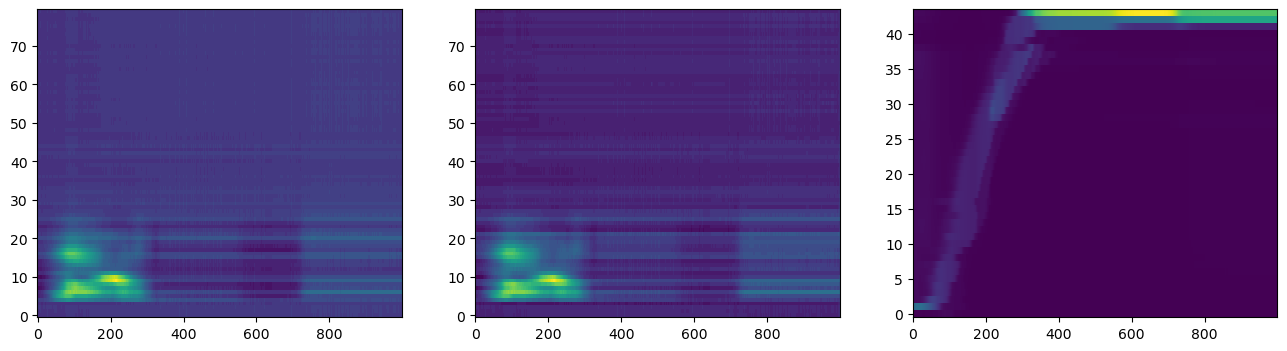

In [166]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [167]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [89]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 

/home/ubuntu/workspace/TTS/tacotron2/audio_processing.py:50: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  win_sq = librosa_util.pad_center(win_sq, n_fft)


In [90]:
pwd

'/home/ubuntu/workspace/TTS/tacotron2'

In [91]:
cd ../

/home/ubuntu/workspace/TTS


In [92]:
## 기본 라이브러리 Import
import sys
import numpy as np
import torch
import os
import argparse

## WaveGlow 프로젝트 위치 설정
sys.path.append('waveglow/')
## Tacontron2 프로젝트 위치 설정
sys.path.append('tacotron2/')

## 프로젝트 라이브러리 Import
from hparams import defaults
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from tacotron2.train import load_model
from text import text_to_sequence
from scipy.io.wavfile import write
import IPython.display as ipd
import json
import sys
from waveglow.glow import WaveGlow
from denoiser import Denoiser
from tqdm.notebook import tqdm
import soundfile as sf

## dict->object 변환용
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
def load_checkpoint(checkpoint_path, model):
    assert os.path.isfile(checkpoint_path)
    checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
    model_for_loading = checkpoint_dict['model']
    model.load_state_dict(model_for_loading.state_dict())
    return model
        
class Synthesizer:
    def __init__(self, tacotron_check, waveglow_check):
        hparams = Struct(**defaults)
        hparams.n_mel_channels=80
        hparams.sampling_rate = 22050
        
        self.hparams = hparams
        
        model = load_model(hparams)
        model.load_state_dict(torch.load(tacotron_check)['state_dict'])
        model.cuda().eval()#.half()
        
        self.tacotron = model
        
        with open('/home/ubuntu/workspace/TTS/tacotron2/waveglow/config.json') as f:
            data = f.read()
        config = json.loads(data)
        waveglow_config = config["waveglow_config"]
        
        waveglow = WaveGlow(**waveglow_config)
        waveglow = load_checkpoint(waveglow_check, waveglow)
        waveglow.cuda().eval()
        
        self.denoiser = Denoiser(waveglow)
        self.waveglow = waveglow
        
        
    def inference(self, text):
        assert type(text)==str, "텍스트 하나만 지원합니다."
        sequence = np.array(text_to_sequence(text, ['korean_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        print(sequence, len(sequence))

        mel_outputs, mel_outputs_postnet, _, alignments = self.tacotron.inference(sequence)
        
        
        with torch.no_grad():
            audio = self.waveglow.infer(mel_outputs_postnet, sigma=0.666)
        audio = audio[0].data.cpu().numpy()
        return audio, self.hparams.sampling_rate
    
    ## \n으로 구성된 여러개의 문장 inference 하는 코드
    def inference_phrase(self, phrase, sep_length=4000):
        texts = phrase.split('\n')
        audios = []
        for text in texts:
            if text == '':
                audios.append(np.array([0]*sep_length))
                continue
            audio, sampling_rate = self.inference(text)
            audios.append(audio)
            audios.append(np.array([0]*sep_length))
        return np.hstack(audios[:-1]), sampling_rate
            
    
    def denoise_inference(self, text, sigma=0.666):
        assert type(text)==str, "텍스트 하나만 지원합니다."
        sequence = np.array(text_to_sequence(text, ['korean_cleaners']))[None, :]
        sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
        print(sequence, len(sequence))

        mel_outputs, mel_outputs_postnet, _, alignments = self.tacotron.inference(sequence)
               
        with torch.no_grad():
            audio = self.waveglow.infer(mel_outputs_postnet, sigma=0.666)
            
        
        audio_denoised = self.denoiser(audio, strength=0.01)[:, 0].cpu().numpy()
        return audio_denoised.reshape(-1), self.hparams.sampling_rate

## 체크포인트 설정
tacotron2_checkpoint = '/home/ubuntu/workspace/TTS/tacotron2/output/checkpoint_34000'
waveglow_checkpoint = '/home/ubuntu/workspace/waveglow_38000'

## 음성 합성 모듈 생성
synthesizer = Synthesizer(tacotron2_checkpoint, waveglow_checkpoint)

## 문장 생성
sample_text = '안녕하세요.'
audio, sampling_rate = synthesizer.inference(sample_text)
## 음성 저장하기
sf.write('문장.wav', audio, sampling_rate)

## 구문 생성
sample_phrase = """
타코트론 모델은 음성 생성 길이가 제한되어 있습니다.
"""
audio, sampling_rate = synthesizer.inference_phrase(sample_phrase)
## 음성 저장하기
sf.write('구문.wav', audio, sampling_rate)

tensor([[13, 21, 45,  4, 27, 62, 20, 21, 11, 26, 13, 33, 75,  1]],
       device='cuda:0') 1
Warning! Reached max decoder steps
tensor([[18, 21, 17, 29, 18, 39,  7, 29, 45, 79,  8, 29,  5, 26, 49, 13, 39, 45,
         79, 13, 39, 57, 11, 25, 62, 79, 11, 22, 62, 11, 25, 62, 79,  2, 41, 49,
         13, 41,  2, 21, 79, 14, 26, 20, 21, 45,  5, 32, 13, 25, 79, 13, 41, 61,
         11, 39, 58,  4, 41,  5, 21, 75,  1]], device='cuda:0') 1
Warning! Reached max decoder steps
